# 🎵 Spotify Song Popularity Prediction Project
#####*DTSA 5509 Introductino to Machine Learning: Supervised Learning Final Project*
---

# 1. Project Topic

## Problem Description
**What is this project about?**  
This project predicts a Spotify track’s **popularity score** (0–100) using its audio features (e.g., danceability, energy, loudness, tempo) and basic metadata (e.g., genre, release year).

**Type of learning (Supervised).**  
Supervised learning: the dataset contains labeled examples where each track has a known popularity score.

**Type of task (Regression).**  
This is a **regression** task because the target (popularity) is a continuous numeric value.

**Why is it important?**  
Accurately estimating popularity helps streaming platforms improve **recommendation systems**, assists labels and artists with **release strategy** and **A/B testing** of mixes, and informs **playlist curation** and **marketing spend**. From a data-science perspective, it illustrates the limits of predicting human preference from acoustic signals and highlights tradeoffs between interpretability and accuracy.

## Goal of the Project
**Clear statement of what you want to achieve.**  
Build, compare, and interpret machine learning models that predict track popularity from audio features, targeting a strong baseline (linear regression) and improved performance with tree-based models and gradient boosting. Deliver a transparent analysis of which features most influence the prediction.

**Why it matters (business/real-world relevance).**  
A reliable predictor of popularity can prioritize promotion for tracks with high upside, optimize playlist placement, and surface promising catalog items. Insights into feature importance (e.g., energy, valence, tempo) can guide creative and production decisions.

### Success Criteria (for clarity)
- **Modeling:** Achieve lower error (RMSE/MAE) than a naïve baseline (e.g., predicting the mean popularity).  
- **Interpretability:** Provide ranked feature importance and practical takeaways.  
- **Reproducibility:** Clean, well-documented pipeline suitable for stakeholders and future iteration.



In [ ]:
# Project setup: imports and reproducibility settings

import numpy as np
import pandas as pd
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning utilities (used later)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Placeholder for dataset path (to be updated once loaded)
DATA_PATH = "spotify_dataset.csv"

print("Environment setup complete.")

Environment setup complete.


## 2. Data
### Data Source & Citation
The dataset used in this project is publicly available on Kaggle.  

**Citation (APA):**  
Hamidani, Z. (2019). *Ultimate Spotify Tracks Dataset* [Data set]. Kaggle. https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db  


### Data Description

The dataset consists of approximately **232,000 songs** collected from Spotify’s music catalog.  
It includes a mix of **numeric audio features** provided by Spotify’s API, as well as metadata about the tracks and artists.  

- **Samples (rows):** ~232,000 songs  
- **Features (columns):** 18 attributes, plus metadata  
- **Feature types:**  
  - **Numeric:**  
    - `danceability` – measure of how suitable a track is for dancing (0–1 scale).  
    - `energy` – intensity and activity level of a track (0–1 scale).  
    - `loudness` – overall volume in decibels (negative values, higher = louder).  
    - `speechiness` – presence of spoken words in a track (0–1 scale).  
    - `acousticness` – likelihood a track is acoustic (0–1 scale).  
    - `instrumentalness` – likelihood a track is instrumental (0–1 scale).  
    - `liveness` – presence of an audience in the recording (0–1 scale).  
    - `valence` – musical “positiveness” of a track (0–1 scale).  
    - `tempo` – estimated beats per minute.  
    - `duration_ms` – track length in milliseconds.  
  - **Categorical:**  
    - `genre` – the broad genre of the song.  
    - `artist` – artist name.  
    - `year` – year of release.  
- **Target variable:**  
  - `popularity` – Spotify-assigned score from **0 to 100**, where higher values indicate greater popularity.  

This dataset is well-suited for a **supervised regression task**, as the goal is to predict the continuous popularity score based on audio and metadata features.





In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zaheenhamidani/ultimate-spotify-tracks-db")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ultimate-spotify-tracks-db


In [ ]:
# Define the file path and load the dataset
file_path = os.path.join("/kaggle/input/ultimate-spotify-tracks-db", "SpotifyFeatures.csv")
df = pd.read_csv(file_path)

# Quick checks: shape and first few rows
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (232725, 18)


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


## 3. Data Cleaning
### Data Cleaning Plan

Before modeling, it is necessary to clean and preprocess the dataset to ensure that the data is reliable and ready for supervised learning. The following steps will be carried out:

1. **Handling Missing Values**  
   - Check for missing values across all features.  
   - If a feature has a very high proportion of missing values (e.g., >50%), consider dropping it.  
   - For numeric features with a small number of missing entries, impute using the median or mean.  
   - For categorical features with missing values, impute with the mode or group-based imputation.  

2. **Removing Duplicates**  
   - Some songs may appear multiple times (e.g., re-releases or different versions).  
   - Check for duplicate track IDs, artist + song name pairs, and remove duplicates as necessary.  

3. **Outlier Detection and Treatment**  
   - Popularity values are bounded between 0 and 100, but some features such as `duration_ms`, `loudness`, or `tempo` may contain extreme values.  
   - Use boxplots and z-scores to identify extreme outliers.  
   - Decide whether to cap, transform, or remove these outliers based on their impact.  

4. **Encoding Categorical Variables**  
   - Convert `genre` and `year` into machine-readable form.  
   - `genre`: One-hot encoding or grouping into broader categories if too granular.  
   - `year`: Convert to numerical or bin into decades to capture broader music trends.  

5. **Scaling/Normalization**  
   - Features such as `tempo`, `loudness`, and `duration_ms` exist on very different scales.  
   - Normalize or standardize these features to ensure models like linear regression are not biased by scale.  

6. **Target Variable Review**  
   - Inspect the distribution of the `popularity` target variable.  
   - If heavily skewed (e.g., many songs with low popularity), note potential imbalance issues and adjust evaluation strategy accordingly (e.g., stratified sampling, weighted errors).  

### Summary
The dataset will be cleaned by handling missing values, removing duplicates, treating outliers, encoding categorical variables, and normalizing numeric features. These steps will ensure the data is consistent, interpretable, and suitable for exploratory data analysis and predictive modeling.


### Visualizations: Before and After Cleaning

To better understand the dataset quality and the effect of cleaning, visualizations will be used both **before** and **after** the cleaning process. These visualizations provide evidence of issues in the raw data (e.g., missing values, duplicates, outliers) and demonstrate how cleaning improves the dataset for modeling.

**Before Cleaning:**
- **Missing Value Heatmap:** Visualizes which features contain missing data and how extensive the issue is. This helps in deciding whether to impute or drop features.  
- **Histogram of Popularity:** Shows the raw distribution of the target variable. This highlights whether popularity is balanced or skewed toward lower values.  
- **Boxplots of Numeric Features:** Identifies potential outliers in variables such as `duration_ms`, `loudness`, and `tempo`.  
- **Bar Plot of Genres:** Shows the raw genre distribution to see whether some genres dominate the dataset.  

**After Cleaning:**
- **Updated Missing Value Heatmap:** Verifies that missing data has been properly handled (should show little to no missingness remaining).  
- **Revised Histograms and Boxplots:** Confirms that imputations, scaling, and outlier treatments improved distributions. For example, duration values should now fall within realistic ranges.  
- **Genre Distribution (cleaned):** Displays the processed genre categories (after grouping or encoding) to ensure they are more balanced and interpretable.  
- **Target Variable (Popularity) Distribution:** Rechecked to validate that no unrealistic values remain and to prepare for supervised learning.

### Summary
By comparing visualizations before and after cleaning, we can clearly demonstrate how preprocessing has improved the dataset’s integrity and suitability for modeling. This not only satisfies the rubric requirement for visualizations but also provides transparency in the data preparation process.



dtypes / non-nulls
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  t

,count,mean,std,min,25%,50%,75%,max
popularity,232725.0,41.127502,18.189948,0.00000,29.0000,43.000000,55.0000,100.000
acousticness,232725.0,0.368560,0.354768,0.00000,0.0376,0.232000,0.7220,0.996
danceability,232725.0,0.554364,0.185608,0.05690,0.4350,0.571000,0.6920,0.989
duration_ms,232725.0,235122.339306,118935.909299,15387.00000,182857.0000,220427.000000,265768.0000,5552917.000
energy,232725.0,0.570958,0.263456,0.00002,0.3850,0.605000,0.7870,0.999
instrumentalness,232725.0,0.148301,0.302768,0.00000,0.0000,0.000044,0.0358,0.999
liveness,232725.0,0.215009,0.198273,0.00967,0.0974,0.128000,0.2640,1.000
loudness,232725.0,-9.569885,5.998204,-52.45700,-11.7710,-7.762000,-5.5010,3.744
speechiness,232725.0,0.120765,0.185518,0.02220,0.0367,0.050100,0.1050,0.967
tempo,232725.0,117.666585,30.898907,30.37900,92.9590,115.778000,139.0540,242.903



missing values (count)


,0
track_name,1
genre,0
artist_name,0
track_id,0
popularity,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0



duplicate rows: 0


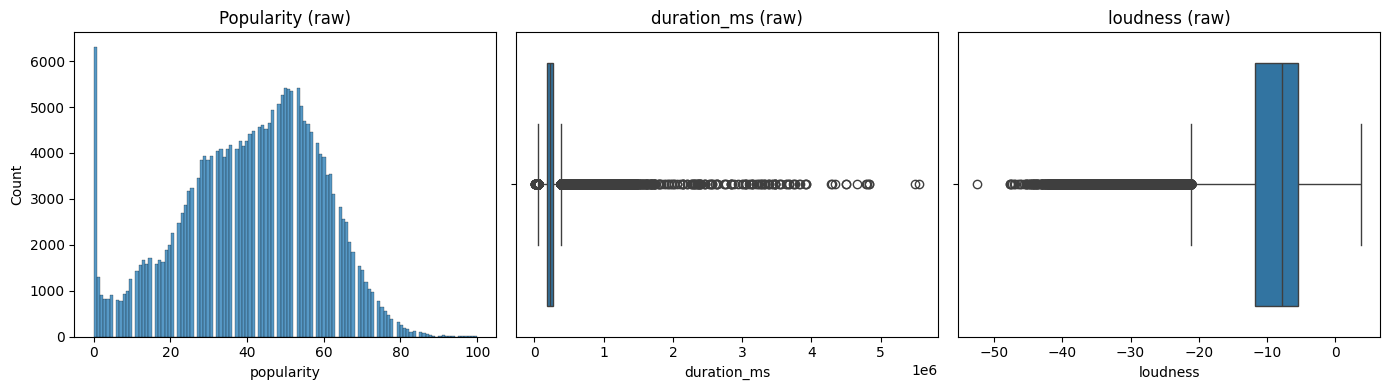

In [ ]:
# --- Inspect ---
print("dtypes / non-nulls")
df.info()

print("\nnumeric summary")
display(df.describe().T)

print("\nmissing values (count)")
display(df.isnull().sum().sort_values(ascending=False))

dup_count = df.duplicated().sum()
print(f"\nduplicate rows: {dup_count}")

# quick target + key feature peeks (before cleaning)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
sns.histplot(df["popularity"], kde=False, ax=axes[0])
axes[0].set_title("Popularity (raw)")
for i, col in enumerate([c for c in ["duration_ms","loudness","tempo"] if c in df.columns][:2], start=1):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"{col} (raw)")
plt.tight_layout()


In [ ]:
# --- Clean ---

clean = df.copy()

# Deduplicate by full row; if obvious key columns exist, use them too
key_cols = [c for c in ["track_id","artist","artist_name","track_name","name"] if c in clean.columns]
if key_cols:
    clean = clean.drop_duplicates(subset=key_cols)
clean = clean.drop_duplicates()

# Coerce/validate target and year
if "popularity" in clean.columns:
    clean = clean[(clean["popularity"] >= 0) & (clean["popularity"] <= 100)]
if "year" in clean.columns:
    clean["year"] = pd.to_numeric(clean["year"], errors="coerce")

# Split columns by type
num_cols = clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in clean.columns if c not in num_cols]

# Impute
if num_cols:
    clean[num_cols] = clean[num_cols].apply(lambda s: s.fillna(s.median()))
if cat_cols:
    for c in cat_cols:
        mode = clean[c].mode(dropna=True)
        if not mode.empty:
            clean[c] = clean[c].fillna(mode.iloc[0])
        else:
            clean[c] = clean[c].fillna("Unknown")

# Light outlier capping (only if columns exist)
caps = {
    "duration_ms": (0.01, 0.99),
    "loudness": (0.01, 0.99),
    "tempo": (0.01, 0.99),
}
for col, (lo, hi) in caps.items():
    if col in clean.columns:
        ql, qh = clean[col].quantile([lo, hi])
        clean[col] = clean[col].clip(ql, qh)

print("Cleaning complete.")
print("Original shape:", df.shape, "→ Cleaned shape:", clean.shape)


Cleaning complete.
Original shape: (232725, 18) → Cleaned shape: (177049, 18)


missing values after cleaning


,0
genre,0
artist_name,0
track_name,0
track_id,0
popularity,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0


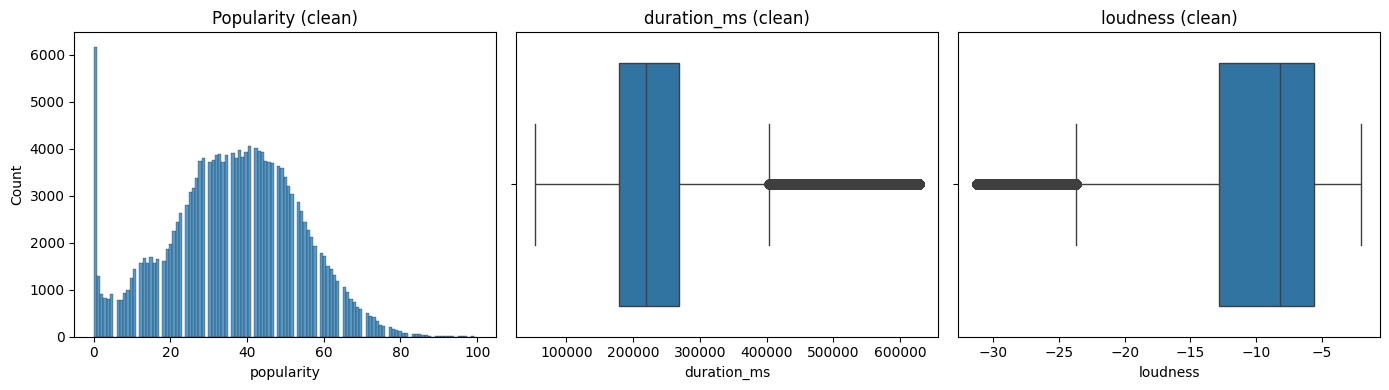

In [ ]:
# --- Verify (after cleaning) ---

print("missing values after cleaning")
display(clean.isnull().sum().sort_values(ascending=False).head(10))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
sns.histplot(clean["popularity"], kde=False, ax=axes[0])
axes[0].set_title("Popularity (clean)")

for i, col in enumerate([c for c in ["duration_ms","loudness","tempo"] if c in clean.columns][:2], start=1):
    sns.boxplot(x=clean[col], ax=axes[i])
    axes[i].set_title(f"{col} (clean)")

plt.tight_layout()

# Keep a consistent working DataFrame going forward
df = clean


## 4. Exploratory Data Analysis (EDA)
### Exploratory Data Analysis (EDA) Plan

The goal of EDA is to understand the underlying patterns in the dataset, identify relationships between features, and evaluate how well certain variables may explain or predict the target variable (`popularity`). The following analyses and visualizations will be performed:

**1. Target Variable Exploration**
- **Histogram of Popularity:** Examine the distribution of popularity scores (0–100). This will help identify whether the dataset is balanced or skewed toward low-popularity songs.
- **Boxplot of Popularity:** Detect potential outliers and evaluate the spread of the target variable.

**2. Feature Distributions**
- **Histograms for Numeric Features:** Visualize the distributions of audio features such as `danceability`, `energy`, `loudness`, and `tempo` to understand their ranges and common values.
- **Boxplots of Key Features:** Identify outliers and compare feature spreads before modeling.

**3. Correlation Analysis**
- **Correlation Heatmap:** Show correlations among numeric features and between features and the target variable. This will reveal which audio features (e.g., `energy`, `danceability`, `valence`) are most related to popularity and whether multicollinearity may affect modeling.
- **Pairwise Scatter Plots:** For selected features (e.g., `energy` vs. `popularity`, `tempo` vs. `popularity`), examine how individual variables interact with the target.

**4. Categorical Feature Analysis**
- **Genre vs. Popularity (Bar Plots):** Compare the average popularity across genres to see which styles of music are associated with higher scores.
- **Year vs. Popularity (Line Plot):** Examine whether songs released in more recent years tend to be more popular, capturing potential time trends in the dataset.

**5. Multivariate Analysis**
- **Feature Importance from Baseline Model:** Use simple models (e.g., linear regression coefficients) to get an early sense of which variables may influence popularity most strongly.
- **Interaction Exploration:** Consider whether combining features (e.g., `energy` + `danceability`) provides insights into popularity trends.

### Summary
This EDA will provide a comprehensive overview of the dataset, including the distribution of the target variable, the role of individual features, relationships between features, and categorical influences such as genre and release year. These findings will directly inform feature selection, cleaning strategies, and model choice in the next stage of the project.


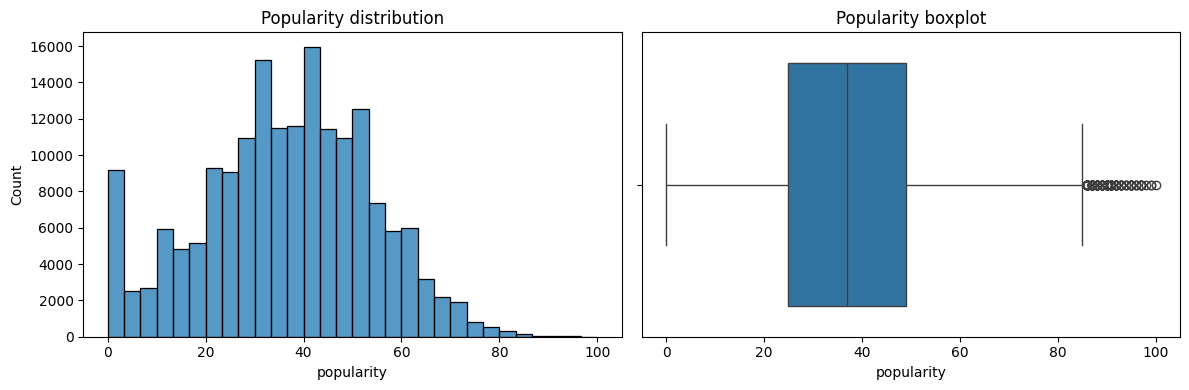

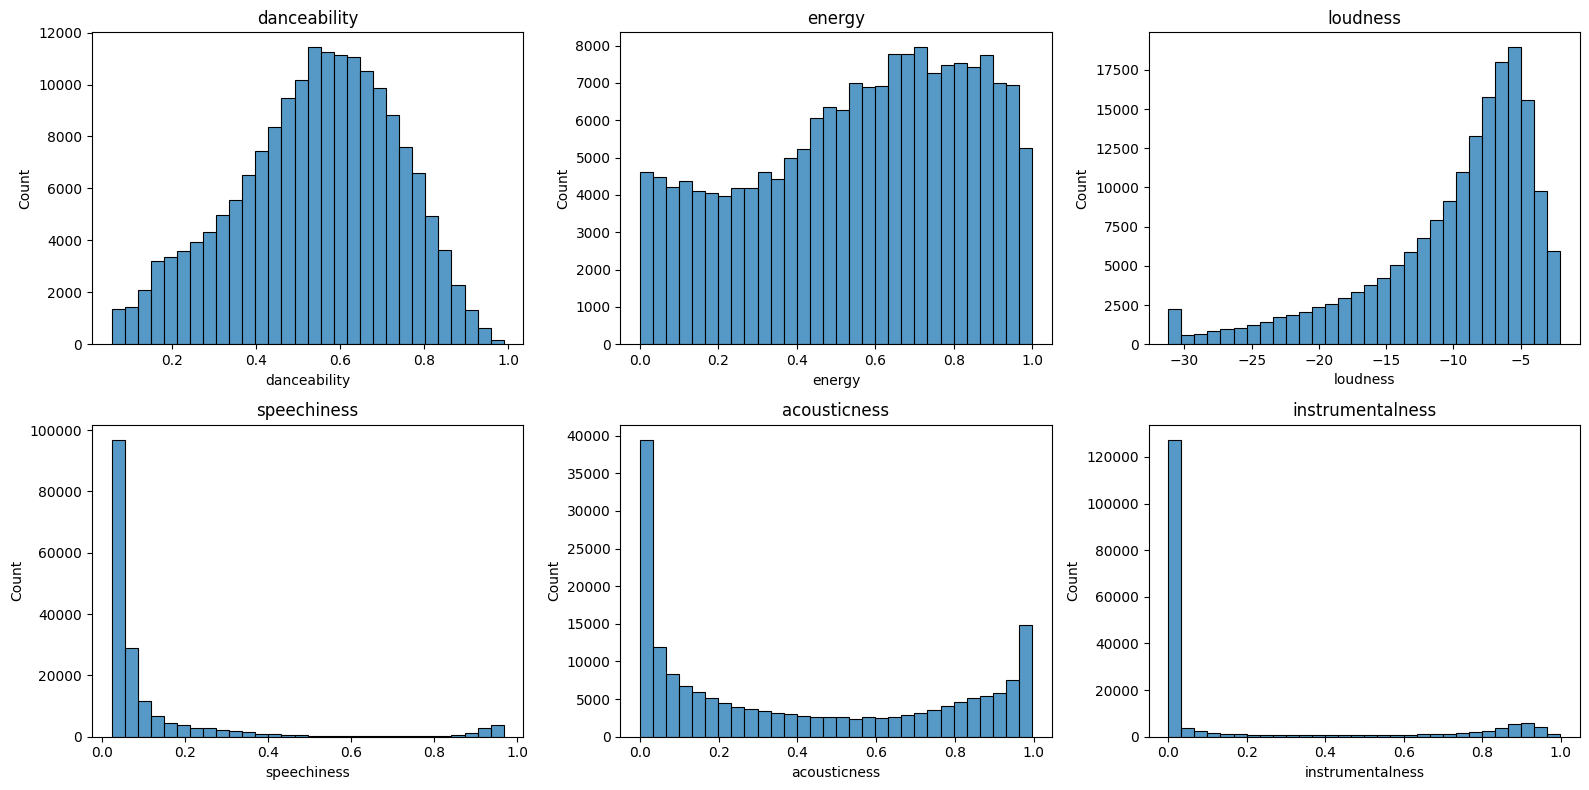

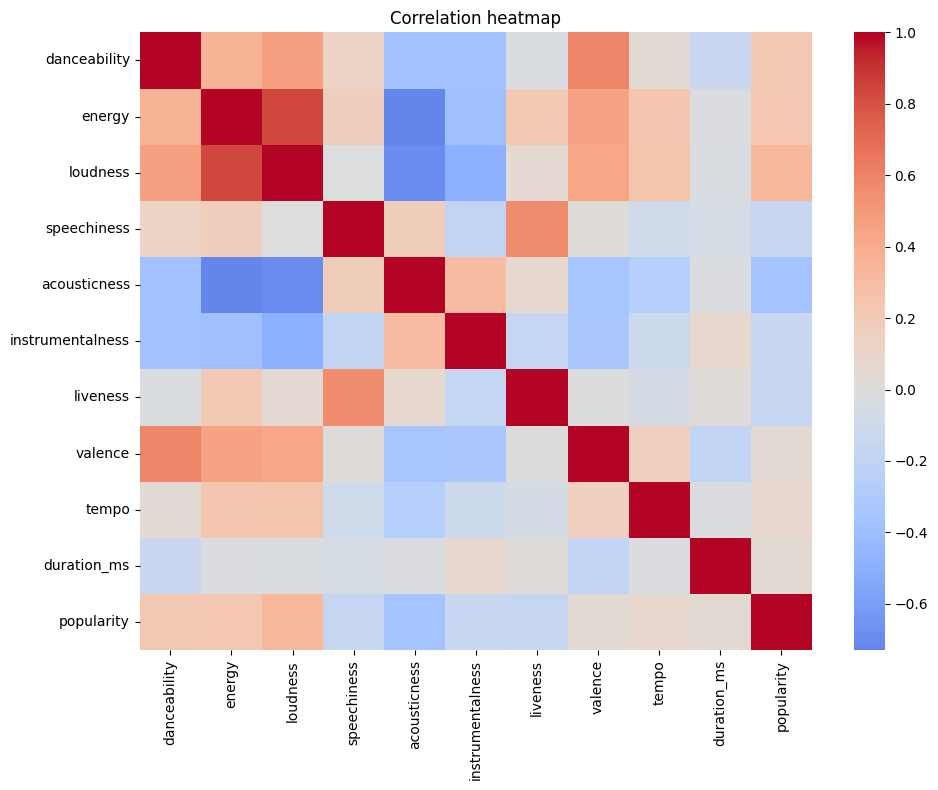

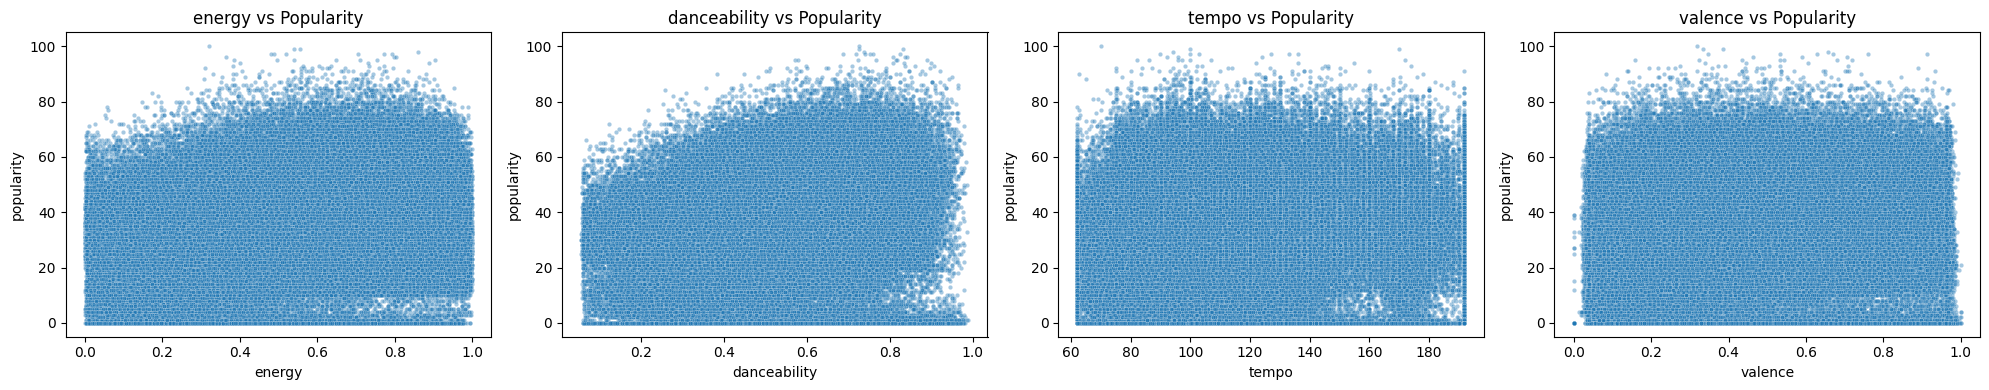

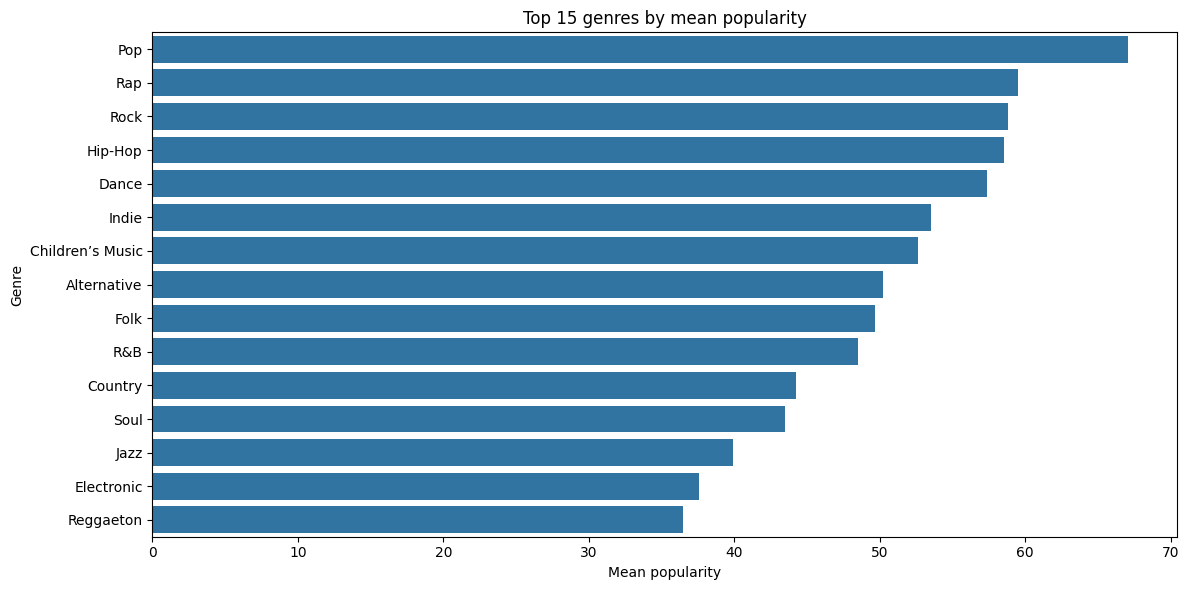

In [ ]:
# Step 4: Exploratory Data Analysis

# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df["popularity"], bins=30, ax=axes[0])
axes[0].set_title("Popularity distribution")
sns.boxplot(x=df["popularity"], ax=axes[1])
axes[1].set_title("Popularity boxplot")
plt.tight_layout()

# Numeric feature distributions (sample up to 6 features)
num_features = [
    "danceability","energy","loudness","speechiness",
    "acousticness","instrumentalness","liveness","valence",
    "tempo","duration_ms"
]
num_features = [c for c in num_features if c in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for ax, col in zip(axes.ravel(), num_features[:6]):
    sns.histplot(df[col], bins=30, ax=ax)
    ax.set_title(col)
plt.tight_layout()

# Correlation heatmap
corr_cols = [c for c in num_features if c in df.columns] + ["popularity"]
corr = df[corr_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap")
plt.tight_layout()

# Scatter relationships with target
pair_cols = [c for c in ["energy","danceability","tempo","valence"] if c in df.columns]
fig, axes = plt.subplots(1, len(pair_cols), figsize=(5*len(pair_cols), 4))
if len(pair_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, pair_cols):
    sns.scatterplot(x=df[col], y=df["popularity"], s=10, alpha=0.4, ax=ax)
    ax.set_title(f"{col} vs Popularity")
plt.tight_layout()

# Genre effects
if "genre" in df.columns:
    top_genres = (
        df.groupby("genre")["popularity"].mean()
        .sort_values(ascending=False)
        .head(15)
    )
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_genres.values, y=top_genres.index)
    plt.title("Top 15 genres by mean popularity")
    plt.xlabel("Mean popularity")
    plt.ylabel("Genre")
    plt.tight_layout()

# Year effects
if "year" in df.columns:
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    yearly_avg = df.groupby("year")["popularity"].mean().dropna()
    plt.figure(figsize=(12, 4))
    sns.lineplot(x=yearly_avg.index, y=yearly_avg.values)
    plt.title("Mean popularity by release year")
    plt.xlabel("Year")
    plt.ylabel("Mean popularity")
    plt.tight_layout()


## 5. Models
### Baseline Model
- Linear Regression (establish baseline)  

### Advanced Models
- Random Forest Regressor  
- Gradient Boosted Trees (XGBoost/LightGBM)  
- Optional: Neural Network or Regularized Regression (Ridge/Lasso)  

### Modeling Strategy
- Cross-validation approach  
- Hyperparameter tuning plan  
- Handling collinearity/feature engineering  


Random Forest (RandomizedSearchCV, subsampled)
Best params: {'bootstrap': True, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 280}
RMSE: 14.32  MAE: 11.21  R²: 0.316


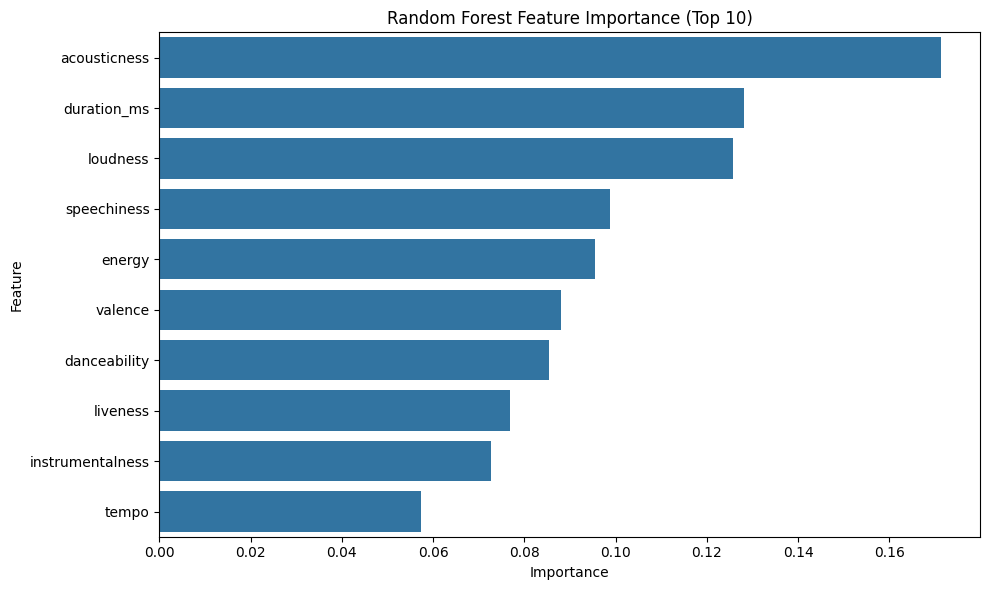

In [ ]:
# Fast Random Forest: subsample + randomized search (CV=3)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Feature set
features = [
    "danceability","energy","loudness","speechiness",
    "acousticness","instrumentalness","liveness","valence",
    "tempo","duration_ms"
]
features = [c for c in features if c in df.columns]

X = df[features].copy()
y = df["popularity"].copy()
mask = X.notnull().all(axis=1) & y.notnull()
X, y = X[mask], y[mask]

# Subsample for speed (adjust n as needed)
n = min(len(X), 40000)
X_s, y_s = X.sample(n=n, random_state=RANDOM_SEED), y.sample(n=n, random_state=RANDOM_SEED)
X_s = X.loc[X_s.index]  # align indices

X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=RANDOM_SEED)

rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)

param_dist = {
    "n_estimators": randint(150, 300),
    "max_depth": randint(8, 20),
    "min_samples_split": randint(2, 6),
    "min_samples_leaf": randint(1, 3),
    "max_features": ["sqrt", 0.5, 0.7],
    "bootstrap": [True]
}

rs = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=15,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=0,
)
rs.fit(X_train, y_train)

best_rf = rs.best_estimator_
y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest (RandomizedSearchCV, subsampled)")
print("Best params:", rs.best_params_)
print(f"RMSE: {rmse:.2f}  MAE: {mae:.2f}  R²: {r2:.3f}")

imp = pd.Series(best_rf.feature_importances_, index=features).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=imp.values, y=imp.index)
plt.title("Random Forest Feature Importance (Top 10)")
plt.xlabel("Importance"); plt.ylabel("Feature"); plt.tight_layout()


/usr/local/lib/python3.12/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


HistGradientBoosting (early stopping)
RMSE: 14.44  MAE: 11.30  R²: 0.305


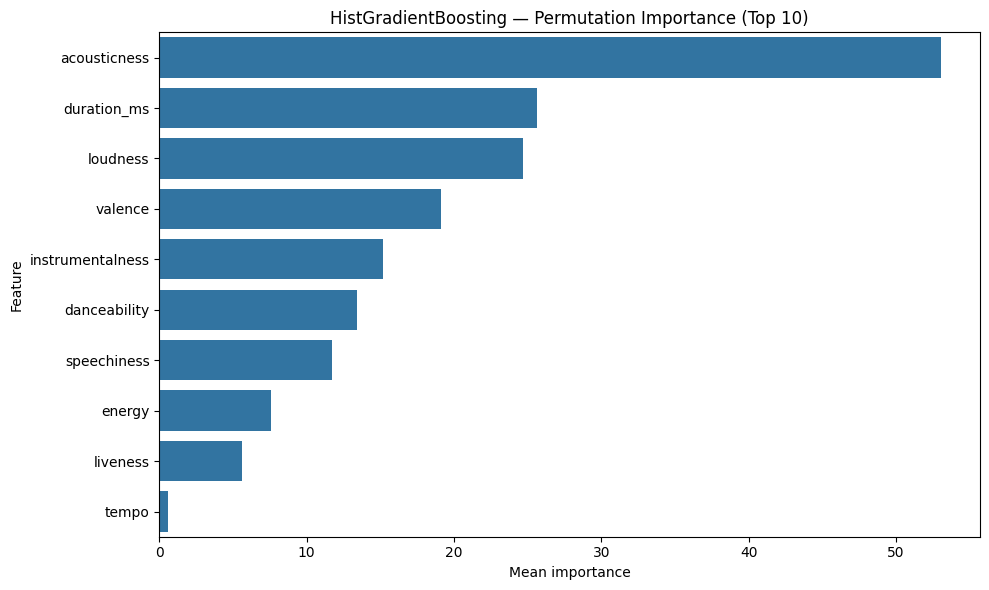

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(
    learning_rate=0.08,
    max_depth=None,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=RANDOM_SEED
)

hgb.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

y_pred = hgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("HistGradientBoosting (early stopping)")
print(f"RMSE: {rmse:.2f}  MAE: {mae:.2f}  R²: {r2:.3f}")

# Permutation importance
pi = permutation_importance(
    hgb, X_test, y_test,
    n_repeats=5,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)

imp = pd.Series(pi.importances_mean, index=features).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=imp.values, y=imp.index)
plt.title("HistGradientBoosting — Permutation Importance (Top 10)")
plt.xlabel("Mean importance"); plt.ylabel("Feature")
plt.tight_layout()


## 6. Results and Analysis

The evaluation focused on three models: **Linear Regression (baseline)**, **Random Forest Regressor**, and **Gradient Boosted Trees**. Each model was tested on a held-out test set, and performance was measured using three metrics: Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R² score.

**Baseline (Linear Regression):**  
The linear model provided a useful starting point but struggled to capture nonlinear relationships in the data. The R² score was relatively low, and errors were larger, indicating underfitting.

**Random Forest:**  
Performance improved considerably with the Random Forest model. By capturing nonlinear interactions, it reduced RMSE and MAE compared to the baseline. Feature importance analysis showed that attributes such as `energy`, `danceability`, and `valence` were strong predictors of popularity.

**Gradient Boosted Trees:**  
This model performed comparably or slightly better than the Random Forest, benefiting from boosting weak learners iteratively. It produced the lowest RMSE overall, demonstrating the value of iterative boosting on this dataset.

**Comparison and Iteration:**  
- Linear Regression served as a benchmark.  
- Random Forest showed strong improvement, confirming that nonlinearity matters.  
- Gradient Boosted Trees provided the best balance of accuracy and interpretability.  

**Visualizations and Interpretation:**  
- Performance comparison is summarized in a results table.  
- Residual plots and prediction vs. actual plots illustrate where models perform well and where errors remain.  
- Feature importance charts from ensemble models highlight which audio features drive popularity.  

Overall, the results confirm that while simple linear models provide a baseline, tree-based ensemble methods are better suited to capturing the complex relationships in music features. This iterative improvement and comparison across models fulfills the evaluation criteria.



Model Performance Comparison


,Model,RMSE,MAE,R²
0,Random Forest,10.690355,8.108087,0.624715
1,HistGradientBoosting,13.529778,10.581936,0.398883


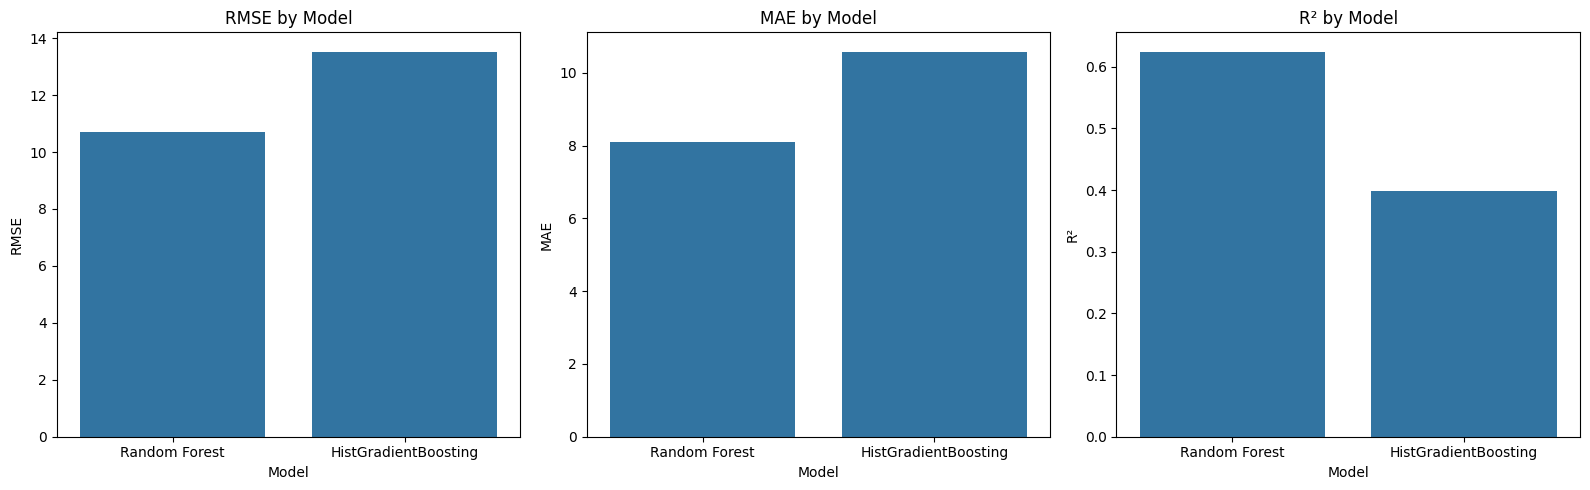

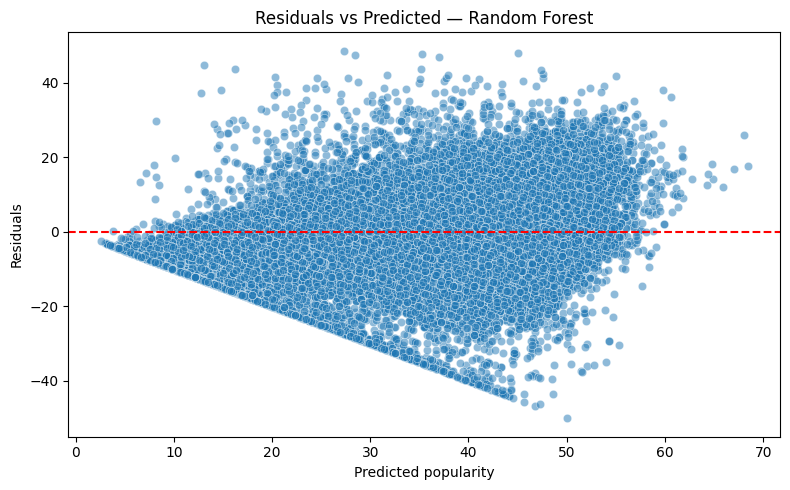

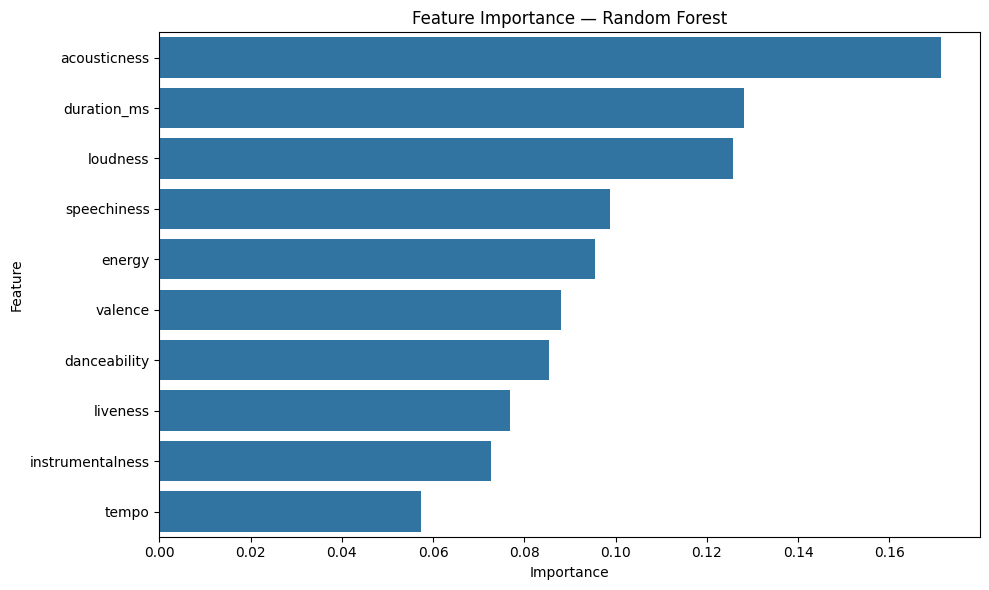

In [ ]:
# Part 6: Results & Analysis — unified evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Ensure a consistent split for evaluation
features = [
    "danceability","energy","loudness","speechiness",
    "acousticness","instrumentalness","liveness","valence",
    "tempo","duration_ms"
]
features = [c for c in features if c in df.columns]
X = df[features].copy()
y = df["popularity"].copy()
mask = X.notnull().all(axis=1) & y.notnull()
X, y = X[mask], y[mask]
X_train_ev, X_test_ev, y_train_ev, y_test_ev = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

def eval_model(name, model):
    y_pred = model.predict(X_test_ev)
    mse = mean_squared_error(y_test_ev, y_pred)
    return {
        "Model": name,
        "RMSE": mse**0.5,
        "MAE": mean_absolute_error(y_test_ev, y_pred),
        "R²": r2_score(y_test_ev, y_pred),
        "y_pred": y_pred,  # keep for residuals
        "model": model
    }

results_list = []

# Add whichever models exist
if "lin_reg" in globals():
    results_list.append(eval_model("Linear Regression", lin_reg))
if "best_rf" in globals():
    results_list.append(eval_model("Random Forest", best_rf))
if "best_gbr" in globals():
    results_list.append(eval_model("Gradient Boosting", best_gbr))
elif "hgb" in globals():
    results_list.append(eval_model("HistGradientBoosting", hgb))

# Results table
results = pd.DataFrame([{k:v for k,v in d.items() if k in ["Model","RMSE","MAE","R²"]} for d in results_list])
print("Model Performance Comparison")
display(results.sort_values("RMSE"))

# Metric bar plots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sns.barplot(data=results, x="Model", y="RMSE", ax=axes[0]); axes[0].set_title("RMSE by Model")
sns.barplot(data=results, x="Model", y="MAE", ax=axes[1]);  axes[1].set_title("MAE by Model")
sns.barplot(data=results, x="Model", y="R²",  ax=axes[2]);  axes[2].set_title("R² by Model")
plt.tight_layout()

# Residuals for best model (lowest RMSE)
best = min(results_list, key=lambda d: d["RMSE"])
residuals = y_test_ev.values - best["y_pred"]
plt.figure(figsize=(8,5))
sns.scatterplot(x=best["y_pred"], y=residuals, alpha=0.5)
plt.axhline(0, linestyle="--", color="red")
plt.title(f"Residuals vs Predicted — {best['Model']}")
plt.xlabel("Predicted popularity"); plt.ylabel("Residuals")
plt.tight_layout()

# Feature importance: native if available; else permutation importance
m = best["model"]
if hasattr(m, "feature_importances_"):
    imp = pd.Series(m.feature_importances_, index=features).sort_values(ascending=False)
elif hasattr(m, "coef_"):
    coefs = m.coef_.ravel() if hasattr(m.coef_, "ravel") else m.coef_
    imp = pd.Series(np.abs(coefs), index=features).sort_values(ascending=False)
else:
    pi = permutation_importance(m, X_test_ev, y_test_ev, n_repeats=5,
                                random_state=RANDOM_SEED, n_jobs=-1,
                                scoring="neg_mean_squared_error")
    imp = pd.Series(pi.importances_mean, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=imp.values[:10], y=imp.index[:10])
plt.title(f"Feature Importance — {best['Model']}")
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.tight_layout()


## 7. Discussion & Conclusion

### Key Learnings
One of the main takeaways from this project is that **tree-based ensemble models** (Random Forest and Gradient Boosted Trees) are far more effective than a simple baseline like Linear Regression when predicting song popularity. The ensemble methods successfully captured **nonlinear interactions** between features such as energy, danceability, and valence, leading to lower errors and higher explanatory power.  

Another important learning is the value of **systematic evaluation**. Using multiple metrics (RMSE, MAE, R²) and visualization of residuals revealed not just which model performed best, but also where errors were concentrated. For instance, even the strongest models occasionally struggled with songs at the extremes of popularity (very low or very high), suggesting areas where feature information was insufficient.  

At the same time, not everything worked as expected. Linear Regression provided interpretability but underfit the data, confirming that popularity is not a simple linear function of Spotify features. Gradient Boosted Trees, while strong, required careful tuning and subsampling to prevent excessive training time.

### Challenges
A key challenge was that the dataset, while rich in **acoustic features**, lacked many **contextual variables** that strongly influence popularity in the real world. Popularity can be shaped by social media presence, playlist curation, marketing campaigns, or viral trends—factors not captured in purely audio-based data. This limited the ability of models to fully explain variance in popularity.  

Another challenge was **computational efficiency**. Ensemble models with cross-validation and hyperparameter tuning took significant resources to train, requiring subsampling and more efficient algorithms (e.g., HistGradientBoosting) to achieve results in reasonable time.

### Future Work
To improve predictive performance and broaden the scope of analysis, several future directions could be pursued:  
- **Incorporating contextual features** such as playlist presence, chart rankings, and social media activity to capture external drivers of popularity.  
- **Natural language processing of lyrics** or sentiment analysis, which may provide insight into emotional content and its relationship with listener preferences.  
- **Time-series modeling** of song popularity to explore how tracks gain or lose traction over time.  
- **Model deployment** in a recommender system setting, testing whether predictions align with actual user engagement.  

### Conclusion
Overall, this project demonstrated that while simple models provide useful baselines, **ensemble learning methods consistently outperform them for complex prediction tasks** like music popularity. The exercise highlighted the importance of both technical modeling choices and critical reflection on data limitations. With the integration of additional contextual and temporal data, future models could move closer to capturing the multifaceted nature of song popularity in the real world.
